# Time Series in a Circular District Heating Grid

This example demonstrates how to perform a time series simulation for a district heating network using pandapipes. It builds upon the simple circular district heating grid described in the notebook 'circular_flow_in_a_district_heating_grid.ipynb'.

In real-world district heating systems, the heat demand and operating conditions change over time. Time series simulations allow you to analyze the dynamic behavior of the network, such as how temperature, pressure, and flow rates evolve in response to varying consumer demands or external conditions.

In this notebook, you will learn:

- How to set up a district heating network for time series analysis with pandapipes.
- How to define time-dependent input data (e.g., heat demand profiles).
- How to run a time series simulation and log relevant results.
- How to visualize and interpret the results over multiple time steps.

This approach is essential for designing and optimizing district heating systems, ensuring reliable operation under varying load conditions, and evaluating control strategies.

<img src="../pics/district_heating/time_series_district_heating_net_text.png">

## Network Setup

The network used in this example is based on a circular district heating grid with several branches and consumers. The setup includes:

- A main pump that supplies hot water to the network.
- Multiple junctions representing supply and return points for each consumer branch.
- Pipes connecting the junctions, forming a closed loop with additional branches for each consumer.
- Several heat consumers, each with its own heat demand and return temperature profile.

This structure allows for the simulation of realistic operating scenarios, where heat demand and return temperatures can vary over time for each consumer. The network is initialized with water as the working fluid.

In [165]:
import pandapipes as pp
import numpy as np

# create empty net
net = pp.create_empty_network(fluid ="water")

In [166]:
# define constants
qext_w = np.array([100000, 80000, 120000])
return_temperature_k = np.array([60,55,65]) + 273.15
supply_temperature_k = 85 + 273.15

pipetype = "110/202 PLUS"
k = 0.1

flow_pressure_pump = 4
lift_pressure_pump = 1.5
mass_pump_mass_flow = 0.5

In [167]:
# Define junctions
j1 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Pump Supply", geodata=(0, 0))
j2 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Main Split Supply", geodata=(10, 0))
j12 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Main Split Return", geodata=(10, 10))
j13 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Pump Return", geodata=(0, 10))

# Additional junctions for new branches
j3 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Consumer B Supply", geodata=(20, 0))
j4 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Consumer B Return", geodata=(20, 10))
j5 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Consumer C Supply", geodata=(30, 0))
j6 = pp.create_junction(net, pn_bar=1.05, tfluid_k=supply_temperature_k, name="Consumer C Return", geodata=(30, 10))

# Pump
pp.create_circ_pump_const_pressure(net, j13, j1, p_flow_bar=flow_pressure_pump, plift_bar=lift_pressure_pump, 
                                t_flow_k=supply_temperature_k, type="auto", name="Main Pump")

# Pipes for supply line
pp.create_pipe(net, j1, j2, std_type=pipetype, length_km=0.2, k_mm=k, name="Main Pipe Supply")
pp.create_pipe(net, j2, j3, std_type=pipetype, length_km=0.3, k_mm=k, name="Branch B Pipe Supply")
pp.create_pipe(net, j3, j5, std_type=pipetype, length_km=0.3, k_mm=k, name="Branch C Pipe Supply")

# Pipes for return line
pp.create_pipe(net, j12, j13, std_type=pipetype, length_km=0.2, k_mm=k, name="Main Pipe Return")
pp.create_pipe(net, j4, j12, std_type=pipetype, length_km=0.3, k_mm=k, name="Branch B Pipe Return")
pp.create_pipe(net, j6, j4, std_type=pipetype, length_km=0.3, k_mm=k, name="Branch C Pipe Return")

# Heat consumers
pp.create_heat_consumer(net, from_junction=j2, to_junction=j12, qext_w=qext_w[0], treturn_k=return_temperature_k[0], name="Consumer A")
pp.create_heat_consumer(net, from_junction=j3, to_junction=j4, qext_w=qext_w[1], treturn_k=return_temperature_k[1], name="Consumer B")
pp.create_heat_consumer(net, from_junction=j5, to_junction=j6, qext_w=qext_w[2], treturn_k=return_temperature_k[2], name="Consumer C")

2

## Plotting Net

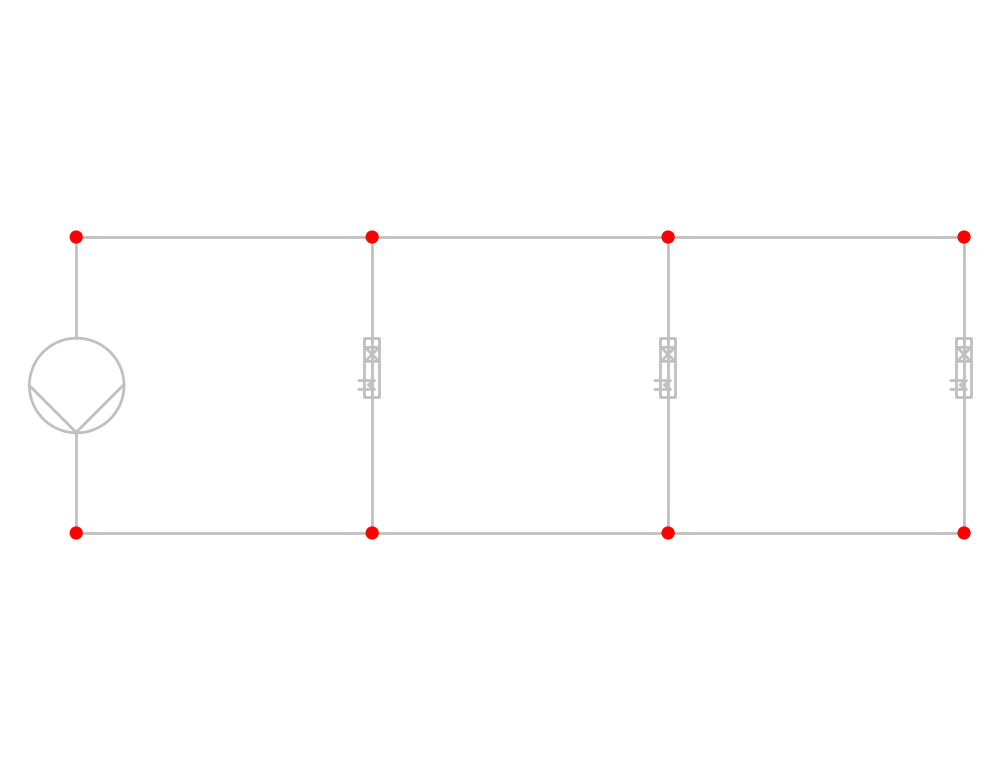

<Axes: >

In [168]:
pp.plotting.simple_plot(net)

## Pipeflow Calculation

To analyze the dynamic behavior of the network, we perform a pipe flow calculation for each time step. The `pipeflow` function is called in bidirectional mode, which is necessary for networks with heat exchange, as it enables the simultaneous calculation of hydraulic and thermal behavior.

The number of iterations (`iter=100`) and the relaxation parameter (`alpha=0.2`) can be adjusted to ensure convergence, especially for larger or more complex networks. These settings help the solver handle changing conditions across the time series.

In [169]:
pp.pipeflow(net, mode='bidirectional', iter=100, alpha=0.2)

## Time Series Simulation

In this section, we set up and run a time series simulation for the district heating network. The simulation considers time-dependent changes in both the supply temperature and the heat demand of each consumer.

- The supply temperature at the pump is varied over time using a predefined temperature profile, representing realistic operational changes (e.g., day/night or seasonal effects).
- The heat demand for each consumer is defined as a time-dependent profile, allowing for different demand patterns at each time step. This enables the simulation of varying consumer behavior or external influences.
- These time-dependent values are assigned to the network using `ConstControl` controllers from pandapower.timeseries, which update the relevant parameters (supply temperature and consumer heat extraction) at each time step based on the provided profiles.

The simulation is executed using the `run_time_series` function, which solves the network for each time step and logs the results using an `OutputWriter`. This approach enables the analysis of how the network responds to dynamic operating conditions, such as fluctuating supply temperatures and varying consumer demands.

By combining time-dependent input data with automated controllers, you can analyze the behavior of the district heating grid and evaluate the impact of different control strategies or demand scenarios.

In [170]:
start = 0
end = 10 # 8760 hours in a year

# time steps with start and end
time_steps = np.arange(start, end, 1)	# time steps in hours

supply_temperature_profile_k = np.array([90, 85, 80, 75, 75, 75, 75, 80, 85, 95]) + 273.15

# Define percentage profiles for each consumer (shape: [n_timesteps, n_consumers])
heat_demand_percentages = np.array([
    [1.0, 0.8, 1.2],  # t=0
    [0.9, 0.7, 1.1],  # t=1
    [0.8, 0.6, 1.0],  # t=2
    [0.7, 0.5, 0.9],  # t=3
    [0.6, 0.4, 0.8],  # t=4
    [0.7, 0.5, 0.9],  # t=5
    [0.8, 0.6, 1.0],  # t=6
    [0.9, 0.7, 1.1],  # t=7
    [1.0, 0.8, 1.2],  # t=8
    [1.0, 0.8, 1.2],  # t=9
])

# Calculate time-dependent qext for each consumer
qext_profile = qext_w * heat_demand_percentages  # shape: (n_timesteps, n_consumers)
print(f"Time dependant heat demand profile for the three consumers: \n {qext_profile}")

Time dependant heat demand profile for the three consumers: 
 [[100000.  64000. 144000.]
 [ 90000.  56000. 132000.]
 [ 80000.  48000. 120000.]
 [ 70000.  40000. 108000.]
 [ 60000.  32000.  96000.]
 [ 70000.  40000. 108000.]
 [ 80000.  48000. 120000.]
 [ 90000.  56000. 132000.]
 [100000.  64000. 144000.]
 [100000.  64000. 144000.]]


### Data Setup and Controller Definition

To enable time-dependent simulation, we need to provide the network with profiles for all parameters that change over time. In this example, both the supply temperature at the pump and the heat demand for each consumer are defined as time series.

- **Heat demand profiles:** For each consumer, a time-dependent heat extraction profile (`qext_w`) is created. These profiles are stored in a pandas DataFrame and provided to the controllers using `DFData`.
- **Supply temperature profile:** The supply temperature at the pump is also defined as a time series and provided to the controller in the same way.

The `ConstControl` class from `pandapower.control` is used to assign these profiles to the corresponding network elements. Each controller updates the specified parameter (e.g., `qext_w` for a heat consumer, `t_flow_k` for the pump) at every time step according to the profile.

This setup allows the simulation to automatically adjust the network's operating conditions at each time step, enabling the analysis of dynamic scenarios and the impact of different demand or supply strategies.

In [171]:
import pandas as pd
from pandapower.timeseries import DFData
from pandapower.control.controller.const_control import ConstControl

# Create a DataFrame for all qext profiles
profile_names = [f'qext_profile_{i}' for i in range(qext_profile.shape[1])]
qext_profile_df = pd.DataFrame(qext_profile, columns=profile_names)
qext_profile_data = DFData(qext_profile_df)

for i, hc_idx in enumerate(net.heat_consumer.index):
    ConstControl(
        net,
        element='heat_consumer',
        variable='qext_w',
        element_index=hc_idx,
        profile_name=profile_names[i],
        data_source=qext_profile_data
    )

# Add ConstControl for circ pump pressure temperature (t_flow_k)
supply_temp_profile_df = pd.DataFrame({'supply_temp_profile': supply_temperature_profile_k})
supply_temp_profile_data = DFData(supply_temp_profile_df)

ConstControl(
    net,
    element='circ_pump_pressure',
    variable='t_flow_k',
    element_index=net.circ_pump_pressure.index[0],
    profile_name='supply_temp_profile',
    data_source=supply_temp_profile_data
)

This ConstControl has the following parameters: 

index:             3
json_excludes:     ['self', '__class__']

### Running the Time Series Simulation

With all time-dependent profiles and controllers set up, we can now execute the time series simulation. The `OutputWriter` is used to log selected results (such as pressures, temperatures, and heat extraction) at each time step for later analysis and visualization.

The `run_time_series` function iterates through all defined time steps, automatically updating the network parameters according to the profiles and controllers. This process simulates the dynamic operation of the district heating grid under varying supply and demand conditions.

After the simulation, the logged results can be extracted and visualized to gain insights into the network's transient behavior and to evaluate the effectiveness of different control strategies or demand scenarios.

In [172]:
from pandapipes.timeseries import run_time_series
from pandapower.timeseries import OutputWriter

log_variables = [
        ('res_junction', 'p_bar'),
        ('res_junction', 't_k'),
        ('heat_consumer', 'qext_w'),
        ('res_heat_consumer', 'vdot_m3_per_s'),
        ('res_heat_consumer', 't_from_k'),
        ('res_heat_consumer', 't_to_k'),
        ('res_heat_consumer', 'mdot_from_kg_per_s'),
        ('res_circ_pump_pressure', 'mdot_from_kg_per_s'),
        ('res_circ_pump_pressure', 'p_to_bar'),
        ('res_circ_pump_pressure', 'p_from_bar'),
        ('res_circ_pump_pressure', 't_to_k'),
        ('res_circ_pump_pressure', 't_from_k')
    ]

ow = OutputWriter(net, time_steps, output_path=None, log_variables=log_variables)

run_time_series.run_timeseries(net, time_steps, mode="bidirectional", iter=100, alpha=0.2)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 2 3 4 5 6 7 8 9]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


## Results Extraction

After running the time series simulation, the results are stored in the `OutputWriter` object. These results include time-dependent values for pressures, temperatures, mass flows, and heat extraction at various points in the network.

You can extract and analyze these results to understand how the network responds to changing supply and demand conditions. For example, you might examine the supply temperature at the pump, the mass flow through the main pump, or the heat extraction at each consumer over time.

The following code demonstrates how to access and print selected results from the simulation.

In [173]:
# Extract time series results from OutputWriter
results = ow.output

# Supply temperature at "Pump Supply"
pump_supply_idx = net.junction[net.junction['name'] == "Pump Supply"].index[0]
supply_temp = results['res_junction.t_k'][pump_supply_idx]

# Mass flow at main pump (first and only pump)
mass_flow_pump = results['res_circ_pump_pressure.mdot_from_kg_per_s'][pump_supply_idx]

print("Supply temperature at 'Pump Supply' over time:")
print(supply_temp)
print("\nMass flow at main pump over time:")
print(mass_flow_pump)

Supply temperature at 'Pump Supply' over time:
0    363.15
1    358.15
2    353.15
3    348.15
4    348.15
5    348.15
6    348.15
7    353.15
8    358.15
9    368.15
Name: 0, dtype: float64

Mass flow at main pump over time:
0    2.752428
1    3.060334
2    3.559999
3    4.520676
4    3.981185
5    4.520676
6    5.060498
7    3.945994
8    3.362175
9    2.332136
Name: 0, dtype: float64


## Visualization of Time Series Results

To better understand the dynamic behavior of the district heating network, we visualize key results from the time series simulation. The following plots show:

- Temperatures at important junctions (e.g., pump supply, pump return, and consumer returns) over time.
- Pressures at selected nodes to observe hydraulic changes during the simulation.
- Heat extraction (`qext`) for each consumer, illustrating how demand profiles affect network operation.

These visualizations help identify trends, validate the simulation, and provide insights into the performance and stability of the network under varying conditions.

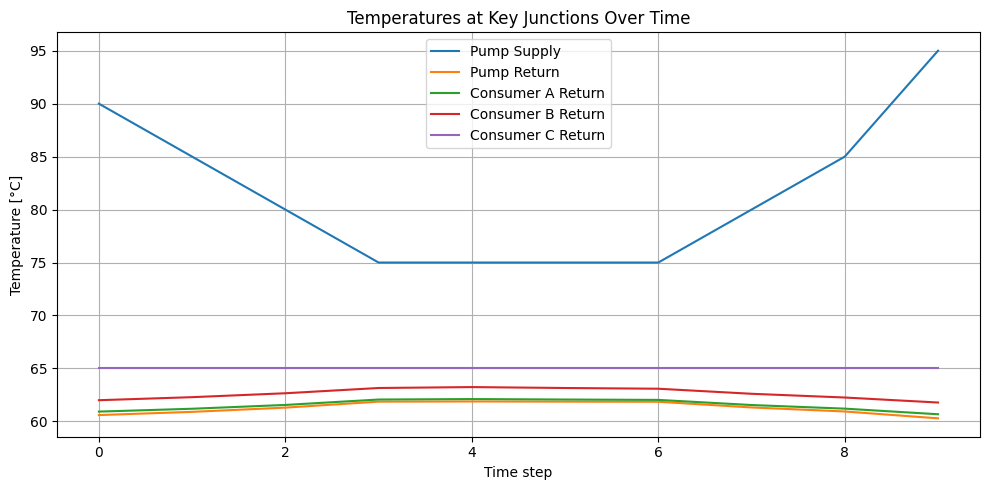

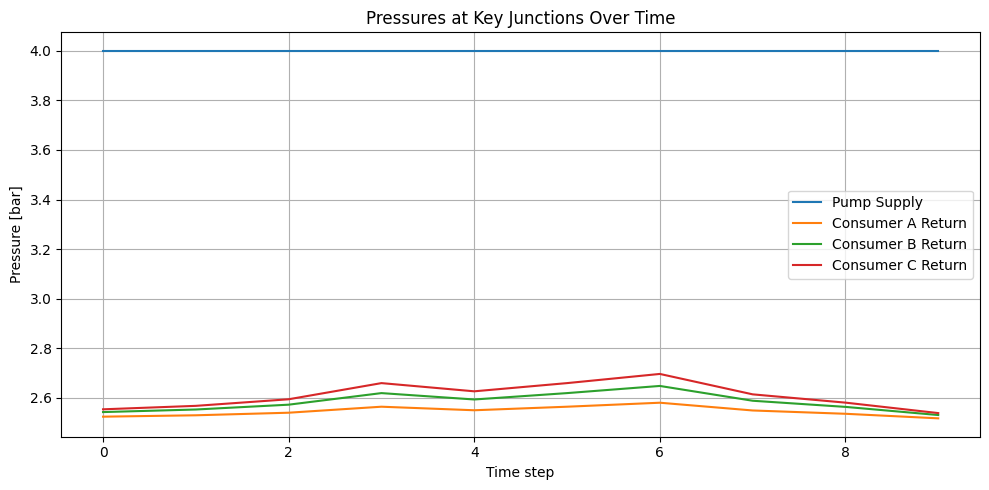

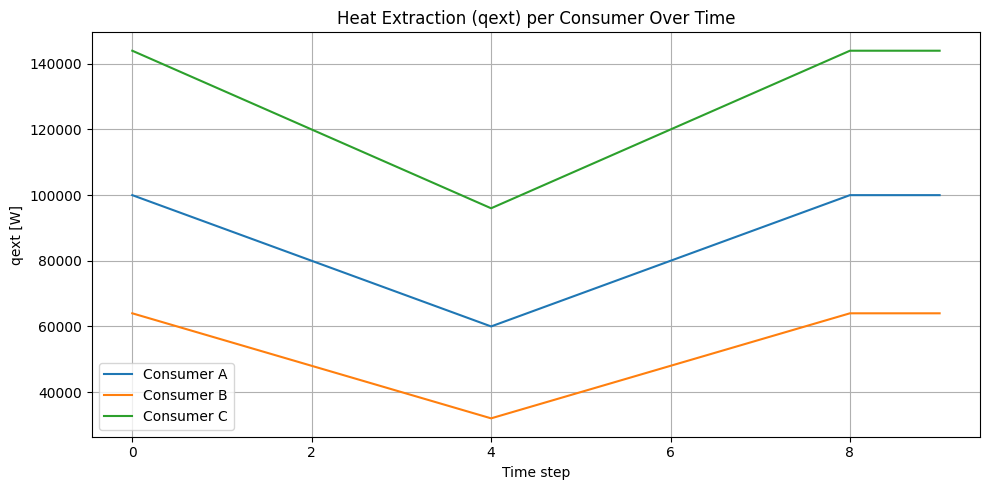

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Load results from OutputWriter
results = ow.output

# The time axis corresponds to the DataFrame index (time steps)
time_steps = results['res_junction.t_k'].index

# --- Temperatures at selected nodes (e.g. Pump Supply, Consumer Returns) ---
pump_supply_idx = net.junction[net.junction['name'] == "Pump Supply"].index[0]
pump_return_idx = net.junction[net.junction['name'] == "Pump Return"].index[0]
consumer_return_idxs = [
    net.junction[net.junction['name'] == "Main Split Return"].index[0],
    net.junction[net.junction['name'] == "Consumer B Return"].index[0],
    net.junction[net.junction['name'] == "Consumer C Return"].index[0],
]

plt.figure(figsize=(10,5))
plt.plot(time_steps, results['res_junction.t_k'][pump_supply_idx] - 273.15, label='Pump Supply')
plt.plot(time_steps, results['res_junction.t_k'][pump_return_idx] - 273.15, label='Pump Return')
for i, idx in enumerate(consumer_return_idxs):
    plt.plot(time_steps, results['res_junction.t_k'][idx] - 273.15, label=f'Consumer {chr(65+i)} Return')
plt.xlabel('Time step')
plt.ylabel('Temperature [°C]')
plt.title('Temperatures at Key Junctions Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Pressures at selected nodes (e.g. Pump Supply, Consumer Returns) ---
plt.figure(figsize=(10,5))
plt.plot(time_steps, results['res_junction.p_bar'][pump_supply_idx], label='Pump Supply')
for i, idx in enumerate(consumer_return_idxs):
    plt.plot(time_steps, results['res_junction.p_bar'][idx], label=f'Consumer {chr(65+i)} Return')
plt.xlabel('Time step')
plt.ylabel('Pressure [bar]')
plt.title('Pressures at Key Junctions Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- qext (Heat Extraction) for all Consumers ---
qext_df = results['heat_consumer.qext_w']
plt.figure(figsize=(10,5))
for i, col in enumerate(qext_df.columns):
    plt.plot(qext_df.index, qext_df[col], label=f'Consumer {chr(65+i)}')
plt.xlabel('Time step')
plt.ylabel('qext [W]')
plt.title('Heat Extraction (qext) per Consumer Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary and Interpretation

The time series simulation and visualizations provide valuable insights into the transient behavior of the district heating grid. By analyzing the results, you can:

- Observe how supply temperature and consumer demands influence network temperatures, pressures, and flows over time.
- Identify periods of high or low demand and assess the network's ability to maintain stable operation.
- Evaluate the effectiveness of control strategies and the impact of different demand scenarios.

These analyses are essential for optimizing district heating systems, improving energy efficiency, and ensuring reliable service under real-world operating conditions. You can further extend this approach by implementing advanced controllers, testing alternative demand profiles, or integrating additional components into the network model.